
# 4.3: Modifying local connectivity

This example demonstrates how to modify the network connectivity.


In [1]:
# Author: Nick Tolley <nicholas_tolley@brown.edu>

import os.path as op

import matplotlib.pyplot as plt

Let us import ``hnn_core``.



In [2]:
import hnn_core
from hnn_core import jones_2009_model, simulate_dipole

--No graphics will be displayed.


To explore how to modify network connectivity, we will start with simulating
the evoked response from the [ERP example](https://dylansdaniels.github.io/website_redesign/content/05_erps/hnn_core.html)
and
explore how it changes with new connections. We first instantiate the
network. (Note: Setting `add_drives_from_params=True` loads a set of
predefined drives without the drives API shown previously).

In [3]:
net_erp = jones_2009_model(add_drives_from_params=True)

Instantiating the network comes with a predefined set of connections that
reflect the canonical neocortical microcircuit. `net.connectivity`
is a list of dictionaries which detail every cell-cell, and drive-cell
connection. The weights of these connections can be visualized with
[hnn_core.viz.plot_connectivity_matrix](https://jonescompneurolab.github.io/hnn-core/stable/generated/hnn_core.viz.plot_connectivity_matrix.html#hnn_core.viz.plot_connectivity_matrix)
as well as
[hnn_core.viz.plot_cell_connectivity](https://jonescompneurolab.github.io/hnn-core/stable/generated/hnn_core.viz.plot_cell_connectivity.html#hnn_core.viz.plot_cell_connectivity).
We can search for specific
connections using `pick_connection` which returns the indices
of `net.connectivity` that match the provided parameters.

38
L5_basket -> L5_pyramidal
cell counts: 35 srcs, 100 targets
connection probability: 1.0 
loc: 'soma'; receptor: 'gabaa'
weight: 0.025; delay: 1.0; lamtha: 70.0
 


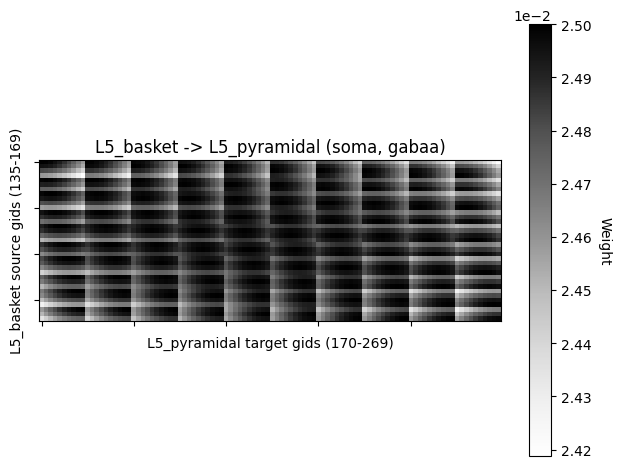

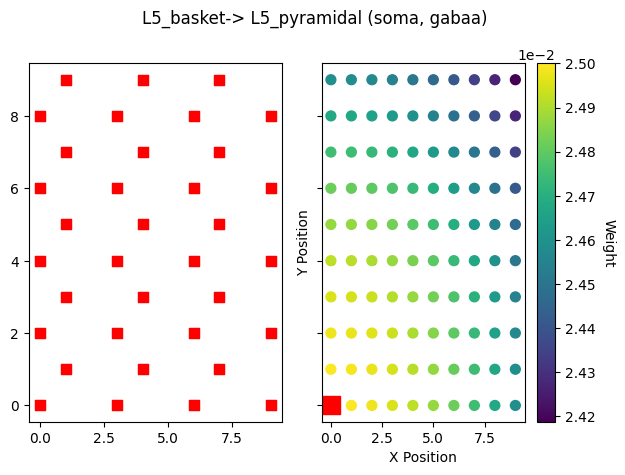

In [4]:
from hnn_core.viz import plot_connectivity_matrix, plot_cell_connectivity, plot_drive_strength
from hnn_core.network import pick_connection

print(len(net_erp.connectivity))

conn_indices = pick_connection(
    net=net_erp, src_gids='L5_basket', target_gids='L5_pyramidal',
    loc='soma', receptor='gabaa')
conn_idx = conn_indices[0]
print(net_erp.connectivity[conn_idx])
plot_connectivity_matrix(net_erp, conn_idx, show=False)

# Note here that `'src_gids'` is a `set` object
# The `.pop()` method can be used to sample a random element
src_gid = net_erp.connectivity[conn_idx]['src_gids'].copy().pop()
fig = plot_cell_connectivity(net_erp, conn_idx, src_gid, show=False)
plt.show()

Data recorded during simulations are stored under
[CellResponse](https://jonescompneurolab.github.io/hnn-core/stable/generated/hnn_core.CellResponse.html#hnn_core.CellResponse).
Spiking activity can be visualized after
a simulation is using 
[CellResponse.plot_spikes_raster](https://jonescompneurolab.github.io/hnn-core/stable/generated/hnn_core.CellResponse.html#hnn_core.CellResponse.plot_spikes_raster):

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...


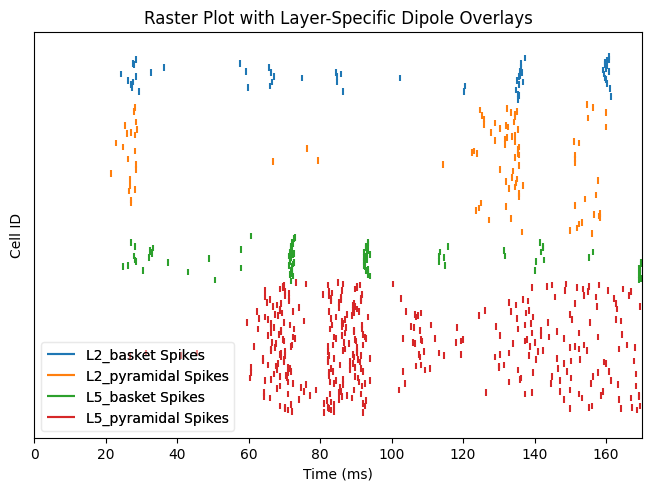

In [5]:
dpl_erp = simulate_dipole(net_erp, tstop=170., n_trials=1)
net_erp.cell_response.plot_spikes_raster(show=False)
plt.show()

We can also define our own connections to test the effect of different
connectivity patterns. To start, ``net.clear_connectivity()`` can be used
to clear all cell-to-cell connections. By default, previously defined drives
to the network are retained, but can be removed with ``net.clear_drives()``.
``net.add_connection`` is then used to create a custom network. Let us first
create an all-to-all connectivity pattern between the L5 pyramidal cells,
and L2 basket cells. 
[Network.add_connection](https://jonescompneurolab.github.io/hnn-core/stable/generated/hnn_core.Network.html#hnn_core.Network.add_connection)
allows connections to be specified with either cell names, or the cell IDs (gids)
directly.

In [6]:
def get_network(probability=1.0):
    net = jones_2009_model(add_drives_from_params=True)
    net.clear_connectivity()

    # Pyramidal cell connections
    location, receptor = 'distal', 'ampa'
    weight, delay, lamtha = 1.0, 1.0, 70
    src = 'L5_pyramidal'
    conn_seed = 3
    for target in ['L5_pyramidal', 'L2_basket']:
        net.add_connection(src, target, location, receptor,
                           delay, weight, lamtha, probability=probability,
                           conn_seed=conn_seed)

    # Basket cell connections
    location, receptor = 'soma', 'gabaa'
    weight, delay, lamtha = 1.0, 1.0, 70
    src = 'L2_basket'
    for target in ['L5_pyramidal', 'L2_basket']:
        net.add_connection(src, target, location, receptor,
                           delay, weight, lamtha, probability=probability,
                           conn_seed=conn_seed)
    return net


net_all = get_network()
dpl_all = simulate_dipole(net_all, tstop=170., n_trials=1)

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...


We can additionally use the ``probability`` argument to create a sparse
connectivity pattern instead of all-to-all. Let's try creating the same
network with a 10% chance of cells connecting to each other.



In [7]:
net_sparse = get_network(probability=0.1)
dpl_sparse = simulate_dipole(net_sparse, tstop=170., n_trials=1)

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...


With the previous connection pattern there appears to be synchronous rhythmic
firing of the L5 pyramidal cells with a period of 10 ms. The synchronous
activity is visible as vertical lines where several cells fire simultaneously
Using the sparse connectivity pattern produced a lot more spiking in
the L5 pyramidal cells.



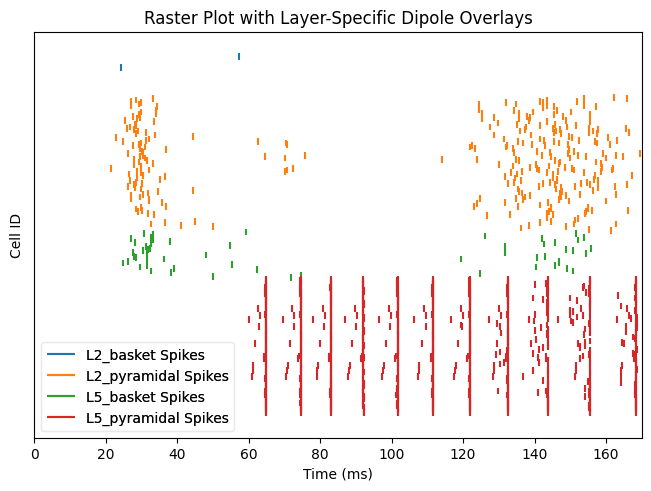

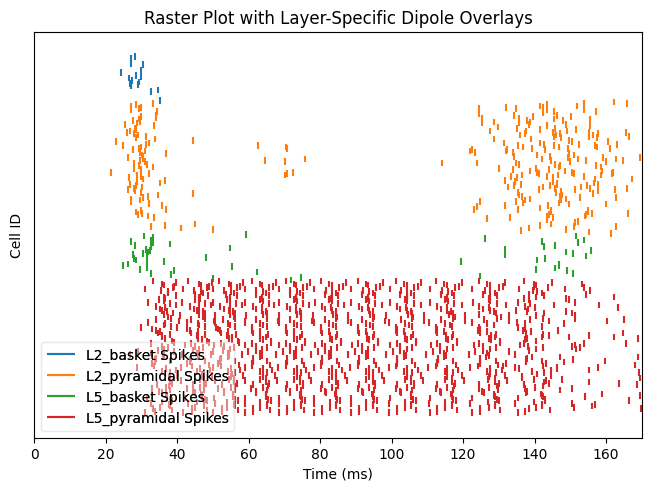

In [8]:
net_all.cell_response.plot_spikes_raster(show=False)
net_sparse.cell_response.plot_spikes_raster(show=False)
plt.show()

We can plot the sparse connectivity pattern between cell populations.



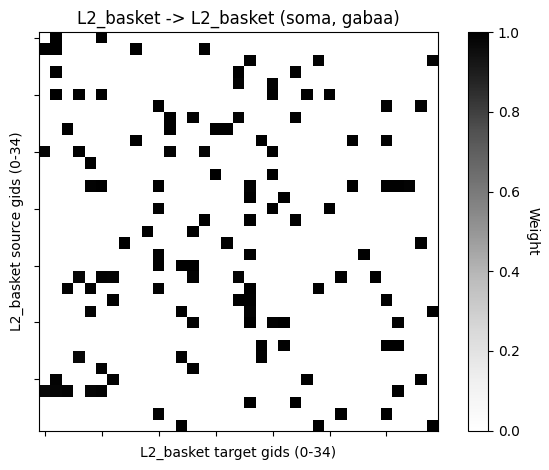

In [9]:
conn_indices = pick_connection(
    net=net_sparse, src_gids='L2_basket', target_gids='L2_basket',
    loc='soma', receptor='gabaa')

conn_idx = conn_indices[0]
plot_connectivity_matrix(net_sparse, conn_idx, show=False)
plt.show()

Note that the sparsity is in addition to the weight decay with distance
from the source cell.



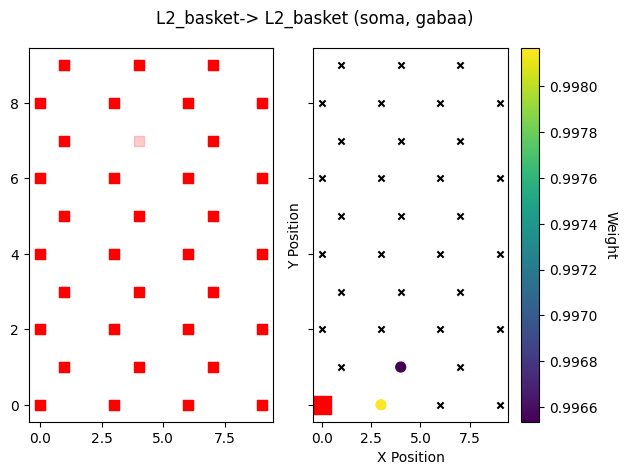

In [10]:
src_gid = net_sparse.connectivity[conn_idx]['src_gids'].copy().pop()
plot_cell_connectivity(net_sparse, conn_idx, src_gid=src_gid, show=False)
plt.show()

We can plot the strengths of each external drive across each cell types.

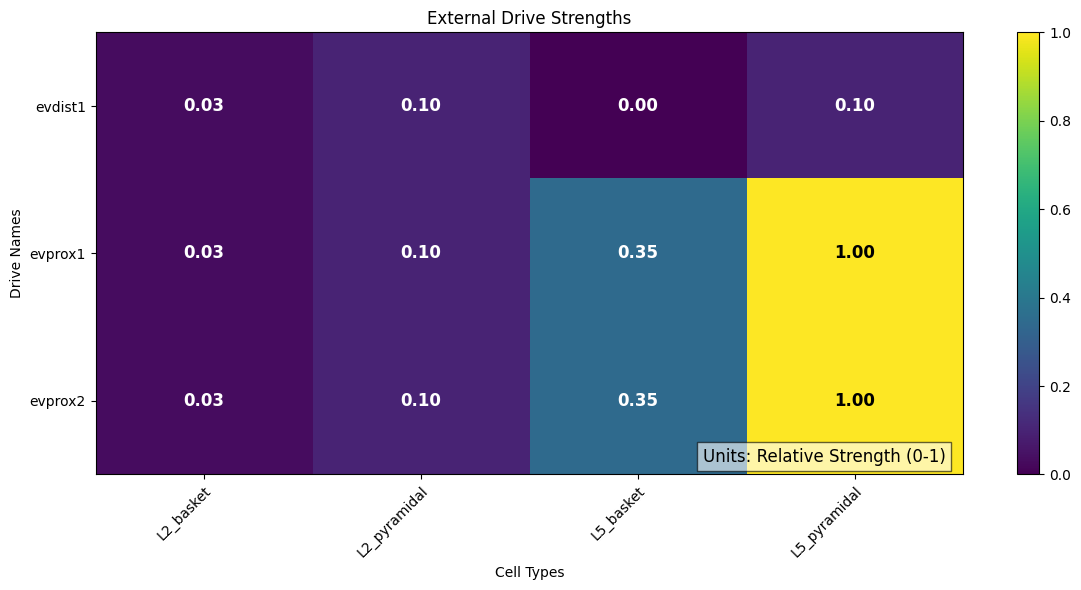

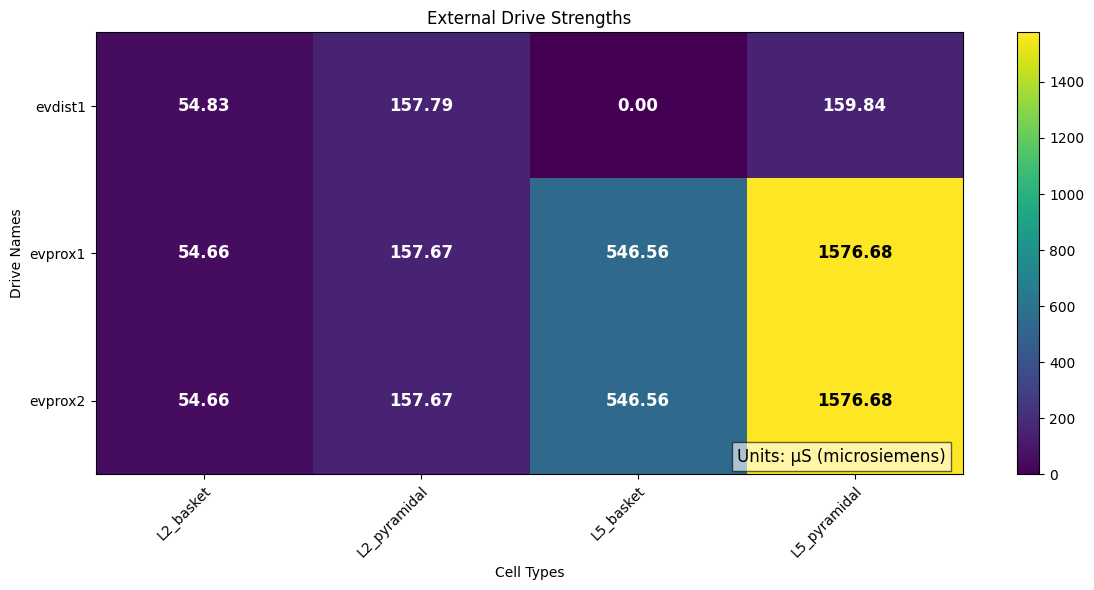

In [11]:
# This can be done in a relative way, enabling you to compare the proportion
# coming from each drive:
plot_drive_strength(net_erp, show=False)

# Alternatively, you can compare the total amount of each drive in conductance:
plot_drive_strength(net_erp, normalize=False, show=False)
plt.show()

In the sparse network, there still appears to be some rhythmicity
where the cells are firing synchronously with a smaller period of 4-5 ms.
As a final step, we can see how this change in spiking activity impacts
the aggregate current dipole.



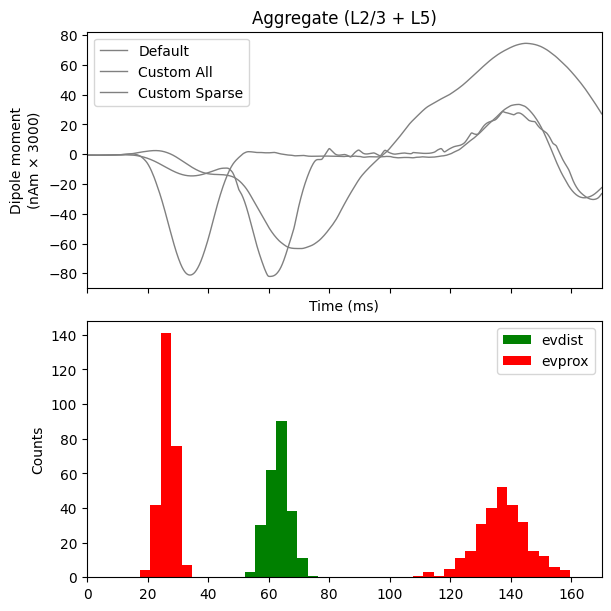

In [12]:
from hnn_core.viz import plot_dipole
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6),
                         constrained_layout=True)

window_len = 30  # ms
scaling_factor = 3000
dpls = [dpl_erp[0].smooth(window_len).scale(scaling_factor),
        dpl_all[0].smooth(window_len).scale(scaling_factor),
        dpl_sparse[0].smooth(window_len).scale(scaling_factor)]

plot_dipole(dpls, ax=axes[0], layer='agg', show=False)
axes[0].legend(['Default', 'Custom All', 'Custom Sparse'])
net_erp.cell_response.plot_spikes_hist(
    ax=axes[1], spike_types=['evprox', 'evdist'], show=False)
plt.show()